# Report6 - 数独

* 姓名：刘权祥
* 学号：2019300414

## 任务简介

数独（shù dú, Sudoku）是源自18世纪[瑞士](https://baike.baidu.com/item/瑞士/131482)的一种数学游戏。是一种运用纸、笔进行演算的[逻辑游戏](https://baike.baidu.com/item/逻辑游戏/12814189)。玩家需要根据9×9盘面上的已知数字，推理出所有剩余空格的数字，并满足每一行、每一列、每一个粗线宫（3*3）内的数字均含1-9，不重复。

数独盘面是个九宫，每一宫又分为九个小格。在这八十一格中给出一定的已知数字和解题条件，利用逻辑和推理，在其他的空格上填入1-9的数字。使1-9每个数字在每一行、每一列和每一宫中都只出现一次，所以又称“九宫格”。

![sudoku_1.jpeg](images/sudoku_1.jpeg)

是否可以用卷积神经网络(CNN)解决数独问题。数独有空间特征，因为它有特殊的数字排列，而CNN擅长提取空间特征，尝试使用CNN来求解数独。



### 数据

这个数据集包含了1百万数独的数据，你可以在这里找到它。

https://www.kaggle.com/bryanpark/sudoku



示例的数据如下所示

![sudoku_data.png](images/sudoku_data.png)



数据集包含2列。`quizzes`栏目是未解的游戏，`solutions`栏目各自的已解游戏。每场比赛都由81个数字组成的字符串表示。以下是从字符串转换而来的9x9数独。数字0代表未解游戏中的空白位置。

```
[[0 0 4 3 0 0 2 0 9]
 [0 0 5 0 0 9 0 0 1]
 [0 7 0 0 6 0 0 4 3]
 [0 0 6 0 0 2 0 8 7]
 [1 9 0 0 0 7 4 0 0]
 [0 5 0 0 8 3 0 0 0]
 [6 0 0 0 0 0 1 0 5]
 [0 0 3 5 0 8 6 9 0]
 [0 4 2 9 1 0 3 0 0]]
```



### 要求

1. 分析数独游戏的特点，设计实现的方法
2. 在Kaggle网站上，下载数据
3. 编写神经网络代码，测试自己算法的效果如何
4. 测试所研究方法的效果
5. 分析自己实现的方法的问题，以及如何改进
6. 深入思考，如何使用强化学习的方法实现求解数独问题？
7. 按照`report_template.ipynb`撰写自己的报告。



### References

* https://www.kaggle.com/bryanpark/sudoku

## 整体思路

#### 分析数独问题并确定解决方案

数独（shù dú, Sudoku）需要我们根据9×9盘面上的已知数字，推理出所有剩余空格的数字，并满足每一行、每一列、每一个粗线宫（3*3）内的数字均含1-9，不重复。

因此，数独是具有空间特征的，它有特殊的数字排列，这样的话，我们就可以尝试使用CNN来提取空间特征，进而通过CNN求解数独问题。

#### 思考解决数独问题的其他方案

但是，在网上查找资料的时候，我了解到CNN解决数独问题的时候，是将整个数独盘作为输入，一次正向传播就直接得到完整的解决方案，这样的话就忽视了目标之间存在的归纳偏置，以及它们是以一致的方式互相作用的，所以在一些情况下CNN模型就会出现问题。

同时，有一部分文章和评论认为使用CNN或者NN解决数独是单纯的用非常多的参数去记住数独的每一个答案，虽然不知道这个观点是否正确，但我觉得就算网络的参数不多，用CNN还是可以解决数独问题的。

CNN做数独的时候是一次性得到完整的解决方案，但我们做数独的时候，实际上是一步一步进行的：我们每次填入一个数字，然后观察这个数字带来的影响。所以数独的解决可以认为是一系列互相依赖的关系推理任务。

因此对于数独问题，循环网络的效果可能比卷积网络要好。按照上面的分析，循环关系网络（RRN）会比较适合数独问题。

#### 解决思路

根据上面的分析，我打算自己实现CNN网络解决数独问题，同时参考网上的资料尝试一下其他的方法，再把这些方法进行对比。

由于没有找到RRN处理数独问题的相关资料，所以我打算尝试一下用RNN解决数独问题，这个部分主要是参照[PyTorch中的数独RNN](https://www.toutiao.com/i6640028992575373828/?tt_from=mobile_qq&utm_campaign=client_share&timestamp=1552006941&app=news_article&utm_source=mobile_qq&iid=65267103732&utm_medium=toutiao_ios&group_id=6640028992575373828&wid=1638801556273)。

## 数据处理

下面是数据处理的相关代码。

这里我利用pandas来读取和处理数据，利用torch.utils.data来打包数据，这样处理后面就可以用DataLoader来加载数据，比较方便。

由于这里我需要同时满足CNN与RNN网络输入输出的要求（其实可以改成同样的，但是RNN部分只是看的差不多懂了，还不太会改，改了就出问题），所以我设置了一个one_hot参数，如果是RNN就使用one hot编码，如果是CNN就直接编码成一个9\*9的矩阵。

In [1]:
import torch.utils.data as data
import torch
import pandas as pd


def create_sudoku_tensors(input_data, one_hot=False, train_split=0.7):
    """
    分割训练集和测试集
    :param input_data: 待分割的数据
    :param one_hot: 是否使用one hot编码
    :param train_split: 分割的比例
    :return: 训练集，测试集
    """
    # 数据的长度
    data_size = input_data.shape[0]

    # 给每一个数独题信息进行编码
    def one_hot_encode(s):
        zeros = torch.zeros((1, 81, 9), dtype=torch.float)
        for a in range(81):
            zeros[0, a, int(s[a]) - 1] = 1 if int(s[a]) > 0 else 0
        return zeros

    # 给每一个数独题信息进行编码
    def encode(s):
        zeros = torch.zeros((1, 9, 9), dtype=torch.float)
        for a in range(9):
            for b in range(9):
                zeros[0, a, b] = int(s[a * 9 + b]) - 1
        return zeros

    # 得到编码内容
    if one_hot:
        quizzes_t = input_data.quizzes.apply(one_hot_encode)
        solutions_t = input_data.solutions.apply(one_hot_encode)
    else:
        quizzes_t = input_data.quizzes.apply(encode)
        solutions_t = input_data.solutions.apply(encode)
    # 将编码好的内容拼接起来
    quizzes_t = torch.cat(quizzes_t.values.tolist())
    solutions_t = torch.cat(solutions_t.values.tolist())

    # 按比例进行随机分割
    randperm = torch.randperm(data_size)
    train = randperm[:int(train_split * data_size)]
    test = randperm[int(train_split * data_size):]

    # 打包训练集和标签
    return data.TensorDataset(quizzes_t[train], solutions_t[train]), \
           data.TensorDataset(quizzes_t[test], solutions_t[test])


def create_constraint_mask():
    """
    创建一个mask
    :return: mask
    """
    constraint_mask = torch.zeros((81, 3, 81), dtype=torch.float)
    # row constraints
    for a in range(81):
        r = 9 * (a // 9)
        for b in range(9):
            constraint_mask[a, 0, r + b] = 1

    # column constraints
    for a in range(81):
        c = a % 9
        for b in range(9):
            constraint_mask[a, 1, c + 9 * b] = 1

    # box constraints
    for a in range(81):
        r = a // 9
        c = a % 9
        br = 3 * 9 * (r // 3)
        bc = 3 * (c // 3)
        for b in range(9):
            r = b % 3
            c = 9 * (b // 3)
            constraint_mask[a, 2, br + bc + r + c] = 1

    return constraint_mask


def load_dataset(filepath, one_hot=False, subsample=10000):
    """
    加载数据集
    :param filepath: 数据集文件
    :param one_hot: 是否使用one hot编码
    :param subsample: 数据集总共的行数
    :return: 训练集、测试集
    """

    dataset = pd.read_csv(filepath, sep=',')
    # 返回随机 subsample 行数据
    my_sample = dataset.sample(subsample)
    # 分割出训练集和测试集
    train_set, test_set = create_sudoku_tensors(my_sample, one_hot)
    return train_set, test_set

通过下面的代码我们可以测试读取的数据格式。

In [9]:
# TEST
train_set, test_set = load_dataset("./src/data/sudoku_test.csv", True, 10)
for train_quiz, train_label in train_set:
    print(train_quiz.shape)
    print(train_label.shape)
    break
train_set, test_set = load_dataset("./src/data/sudoku_test.csv", False, 10)
for train_quiz, train_label in train_set:
    print(train_quiz.shape)
    print(train_label.shape)
    break

torch.Size([81, 9])
torch.Size([81, 9])
torch.Size([9, 9])
torch.Size([9, 9])


## 搭建CNN模型

这里主要是根据report3使用的FashionCNN来搭建的，大体框架基本一样，不过增加了padding，去除了池化层，同时也放弃了dropout层。

这个网络接收N\*1\*9\*9的输入，最后会输出N\*81\*9的预测结果。

N是数据批数，81是9\*9的数独盘面数字列表，9是对于某一个盘面数字，它是每一种数字的概率。（这里数字的取值范围是0-8，但是代表的是数字1-9，这是因为如果取值为1-9，而数独不需要填0，标签中也没有0，所以标签的取值范围还是0-8，这样就等于是标签对应不上，交叉熵损失函数还是会运行失败）


In [2]:
import torch.nn as nn


class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        # 第一层卷积
        # 输入[1,9,9]
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # 9-3+2*1+1
        # 第二层卷积
        # 输入[64,9,9]
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 第三层卷积
        # 输入[64，9，9]
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全连接层
        # 输入[128, 9, 9]
        self.fc1 = nn.Linear(in_features=128 * 9 * 9, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=81 * 9)
        self.fc3 = nn.Softmax(dim=2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # 矩阵展开为向量
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.fc2(out)

        # 向量变化为矩阵（81*9）
        out = out.view(out.shape[0], 81, 9)

        out = self.fc3(out)
        return out


## 训练CNN模型

下面是训练CNN的代码，采用的是Adam优化器和CrossEntropyLoss损失函数。

测试的时候发现这里的学习率要取比较小，取大了loss可能就不下降，或者仅仅是下降了一点点，然后发生震荡。

In [14]:
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset

# 尝试使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载数据集
batch_size = 100
train_set, test_set = load_dataset("./src/data/sudoku.csv", False, 50000)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# 加载模型
model = SudokuCNN()
model.to(device)
# 损失函数
error = nn.CrossEntropyLoss()
# 定义学习率
learning_rate = 0.0005

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 循环次数
num_epochs = 50
# 迭代次数
count = 0
# 是否画图
display = True
# 最小迭代次数
min_epochs = 5
# 最小的损失
min_loss = float('inf')
# 最优模型
best_model = None

# Lists for visualization of loss_function and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    # 　分批次加载数据集
    for train_quiz, train_label in train_loader:
        train_quiz, train_label = train_quiz.to(device), train_label.to(device)
        train_quiz = Variable(train_quiz.view(train_quiz.shape[0], 1, 9, 9))
        train_label = Variable(train_label.view(-1))

        # Forward pass
        outputs = model(train_quiz)
        outputs = outputs.view(-1, 9)

        loss = error(outputs, train_label.long())

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        # Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

        # print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch, count, loss_function.item()))

        # Testing the model
        if not (count % 50):  # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for test_quiz, test_label in test_loader:
                test_quiz, test_label = test_quiz.to(device), test_label.to(device)
                test_quiz = Variable(test_quiz.view(test_quiz.shape[0], 1, 9, 9))
                test_label = Variable(test_label.view(-1))

                outputs = model(test_quiz)
                outputs = outputs.view(-1, 9)

                predictions = torch.max(outputs, 1)[1].to(device)
                correct += (predictions == test_label).sum()

                total += len(test_label)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 100):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 100, Loss: 2.154716968536377, Accuracy: 17.909875869750977%
Iteration: 200, Loss: 2.1245620250701904, Accuracy: 22.032262802124023%
Iteration: 300, Loss: 2.091231107711792, Accuracy: 26.08452606201172%
Iteration: 400, Loss: 2.0490970611572266, Accuracy: 30.193002700805664%
Iteration: 500, Loss: 2.010570764541626, Accuracy: 34.447654724121094%
Iteration: 600, Loss: 1.973477840423584, Accuracy: 38.08658218383789%
Iteration: 700, Loss: 1.9365869760513306, Accuracy: 41.5409049987793%
Iteration: 800, Loss: 1.8946945667266846, Accuracy: 45.34855651855469%
Iteration: 900, Loss: 1.8635038137435913, Accuracy: 48.742549896240234%
Iteration: 1000, Loss: 1.837217092514038, Accuracy: 52.06106948852539%
Iteration: 1100, Loss: 1.8059731721878052, Accuracy: 54.52131652832031%
Iteration: 1200, Loss: 1.7925043106079102, Accuracy: 56.1606559753418%
Iteration: 1300, Loss: 1.7742193937301636, Accuracy: 57.427894592285156%
Iteration: 1400, Loss: 1.7613976001739502, Accuracy: 58.38139724731445%
It

Iteration: 11600, Loss: 1.4533382654190063, Accuracy: 71.38288116455078%
Iteration: 11700, Loss: 1.4505600929260254, Accuracy: 71.39069366455078%
Iteration: 11800, Loss: 1.4487203359603882, Accuracy: 71.51250457763672%
Iteration: 11900, Loss: 1.4499599933624268, Accuracy: 71.6051025390625%
Iteration: 12000, Loss: 1.4480421543121338, Accuracy: 71.55358123779297%
Iteration: 12100, Loss: 1.4436876773834229, Accuracy: 71.3968734741211%
Iteration: 12200, Loss: 1.4521938562393188, Accuracy: 71.55810546875%
Iteration: 12300, Loss: 1.4474445581436157, Accuracy: 71.50106811523438%
Iteration: 12400, Loss: 1.4446181058883667, Accuracy: 71.63514709472656%
Iteration: 12500, Loss: 1.441675066947937, Accuracy: 71.57744598388672%
Iteration: 12600, Loss: 1.4454002380371094, Accuracy: 71.66764831542969%
Iteration: 12700, Loss: 1.4437016248703003, Accuracy: 71.55349731445312%
Iteration: 12800, Loss: 1.4371684789657593, Accuracy: 71.57999420166016%
Iteration: 12900, Loss: 1.442228078842163, Accuracy: 71.6

### 实现过程中出现的问题

前面处理数据和定义模型都挺顺利的，但是训练CNN模型这里出现的问题特别特别多，整个实现过程好像也就这部分出了问题，耽误了比较长的时间。

**这里主要是因为自己对交叉熵损失函数的具体实现过程不太了解，同时对pytorch处理tensor的一些常用手法不太熟练。**

一开始我是用one hot编码在这里训练和测试，但是交叉熵损失函数并不支持one hot编码，并且它还会报错，报错内容大概是“multi target”相关的，这导致我一开始没有精准的定位问题所在，然后我尝试了其他的损失函数，有的可以用但可能因为我**当时的数据格式处理本身有问题**，最后的结果不收敛。所以后面我专门去学习了pytorch中的损失函数，并且也知道了**交叉熵损失函数是不支持one hot编码的。**

之后我就修改了处理数据的代码，让CNN得到9\*9的数据，而RNN继续使用one hot编码。但是因为我的网络计算出来的是batch\*81\*9的，并且标签也是batch\*81的，这样在CrossEntropyLoss函数里面还是会报错，报错内容大概是“期望 batch\*9 但是得到了 batch\*81”。（batch是数据批数）

这里的报错其实也很奇怪，上网查了比较久也没解决这个问题。后面我好好想了一下，**<font color=red>这个数独问题可以理解为一个特殊的分类问题，我们对每一个格子进行分类，判断它是什么数字类型。</font>**这样的话，就很自然的想到要把预测结果和标签都展开，预测结果展开为\[(batch\*81), 9\]的二维矩阵，而标签就展开为\[batch\*81\]的向量。

通过这样的处理方式，我终于能够开始训练这个CNN网络了。（上面找问题找了四五天，不过解决其实就花了一个下午，感觉定位问题的位置很关键！）


#### 一个样例

这里是一个样例代码，我在这个过程中犯的错误用比较简单的形式给再现了出来。

首先定义好各种变量。

In [31]:
import numpy as np
import torch
import torch.nn.functional as F

# 假设这是一个3分类问题，一共有4组样本

# 下面是这个模型的输出
pred_y = np.array([[0.30722019, -0.8358033, -1.24752918],
                   [0.72186664, 0.58657704, -0.25026393],
                   [0.16449865, -0.44255082, 0.68046693],
                   [-0.52082402, 1.71407838, -1.36618063]])
pred_y = torch.from_numpy(pred_y)

# 真实的标签如下所示，很明显这里就是one hot编码
true_y_one_hot = np.array([[1, 0, 0],
                   [0, 1, 0],
                   [0, 1, 0],
                   [0, 0, 1]])
true_y_one_hot = torch.from_numpy(true_y_one_hot)

# 这是采用普通编码的标签
# true_y_1是正确编码的，对于数独问题，我们认为这里的标签实际上代表1，2，2，3
true_y_1 = np.array([0, 1, 1, 2])
true_y_1 = torch.from_numpy(true_y_1)
# true_y_2是错误编码的，这最后会导致输出类型和标签对应不上
true_y_2 = np.array([1, 2, 2, 3])
true_y_2 = torch.from_numpy(true_y_2)

如果使用one hot编码，这样的运行结果如下所示：

In [32]:
loss = F.cross_entropy(pred_y, true_y_one_hot)
print(loss)

RuntimeError: 1D target tensor expected, multi-target not supported

如果编码不正确，输出类型和标签不对应，就会发生下面这样的情况（在数独问题里面其实还要复杂一点）：

In [33]:
loss = F.cross_entropy(pred_y, true_y_2)
print(loss)

IndexError: Target 3 is out of bounds.

正常运行的话，是下面这样的情况：

In [34]:
loss = F.cross_entropy(pred_y, true_y_1)
print(loss)

tensor(1.5929, dtype=torch.float64)


## 测试CNN模型

通过下面的代码可以简单测试训练好的CNN模型。

In [20]:
for test_quiz, test_label in test_loader:
    test_quiz, test_label = test_quiz.to(device), test_label.to(device)
    test_quiz = Variable(test_quiz.view(test_quiz.shape[0], 1, 9, 9))
    test_label = Variable(test_label.view(-1))

    outputs = model(test_quiz)
    outputs = outputs.view(-1, 9)

    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == test_label).sum()

    total += len(test_label)

accuracy = correct * 100 / total

print("Test Accuracy: {}%".format(accuracy))

Test Accuracy: 71.94963073730469%


## 结果可视化

我们可以把训练和测试过程中的损失与准确率画出来。

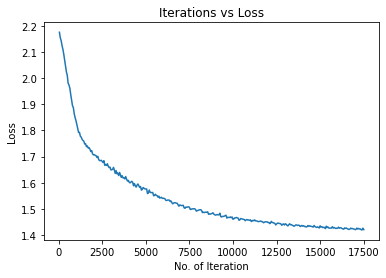

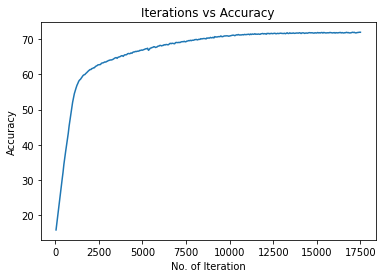

In [15]:
# 画出迭代中的损失
plt.figure(1)
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
# 画出迭代中的准确度
plt.figure(2)
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")

plt.show()

## 尝试使用RNN模型

在一开始做这个项目的时候，我查了很多关于CNN解决数独问题的资料，期间偶然了解到数独用循环网络做的效果会比较好，同时又找到一篇[PyTorch中的数独RNN](https://www.toutiao.com/i6640028992575373828/?tt_from=mobile_qq&utm_campaign=client_share&timestamp=1552006941&app=news_article&utm_source=mobile_qq&iid=65267103732&utm_medium=toutiao_ios&group_id=6640028992575373828&wid=1638801556273)的文章，所以我打算尝试一下RNN模型做数独问题。

在这个环节中，RNN模型是从这篇文章里面搬运过来的，而训练过程有参考这篇文章，但为了和CNN进行对比也做了不少修改。

### 搭建RNN模型

下面是搭建的RNN模型。

In [3]:
import torch
import torch.nn as nn


class SudokuRNN(nn.Module):
    def __init__(self, constraint_mask, n=9, hidden1=100):
        super(SudokuRNN, self).__init__()
        self.constraint_mask = constraint_mask.view(1, n * n, 3, n * n, 1)
        self.n = n
        self.hidden1 = hidden1

        # Feature vector is the 3 constraints
        self.input_size = 3 * n

        self.l1 = nn.Linear(self.input_size,
                            self.hidden1, bias=False)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(self.hidden1,
                            n, bias=False)
        self.softmax = nn.Softmax(dim=1)

    # x is a (batch, n^2, n) tensor
    def forward(self, x):
        n = self.n
        bts = x.shape[0]
        c = self.constraint_mask
        min_empty = (x.sum(dim=2) == 0).sum(dim=1).max()
        x_pred = x.clone()
        for a in range(min_empty):
            # score empty numbers
            constraints = (x.view(bts, 1, 1, n * n, n) * c).sum(dim=3)
            # empty cells
            empty_mask = (x.sum(dim=2) == 0)

            f = constraints.reshape(bts, n * n, 3 * n)
            y_ = self.l2(self.a1(self.l1(f[empty_mask])))

            s_ = self.softmax(y_)

            # Score the rows
            x_pred[empty_mask] = s_

            s = torch.zeros_like(x_pred)
            s[empty_mask] = s_
            # find most probable guess
            score, score_pos = s.max(dim=2)
            mmax = score.max(dim=1)[1]
            # fill it in
            nz = empty_mask.sum(dim=1).nonzero().view(-1)
            mmax_ = mmax[nz]
            ones = torch.ones(nz.shape[0])
            x.index_put_((nz, mmax_, score_pos[nz, mmax_]), ones)
        return x_pred, x

### 训练并测试

In [4]:
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset

# FIXME 这里RNN不能使用GPU，尝试着用就会报错。感觉是定义模型的时候出的问题。。。
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 加载数据集
batch_size = 100
train_set, test_set =load_dataset("./src/data/sudoku.csv", True, 10000)
# train_set, test_set = load_dataset("./data/sudoku_test.csv", True, 1000)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# 加载模型
model = SudokuRNN(create_constraint_mask())
model.to(device)
# 损失函数
loss_fun = nn.MSELoss()
# 定义学习率
learning_rate = 0.01
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.000)
# 循环次数（用cpu训练，不敢弄太大了，训练时间太长）
num_epochs = 1
# 迭代次数
count = 0
# 是否画图
display = True
# 最小迭代次数
min_epochs = 0
# 最小的损失
min_loss = float('inf')
# 最优模型
best_model = None

# Lists for visualization of loss_function and accuracy
loss_list = []
iteration_list = []
accuracy_list = []
accuracy = 0

for epoch in range(num_epochs):
    # 　分批次加载数据集
    for train_quiz, train_label in train_loader:
        train_quiz, train_label = train_quiz.to(device), train_label.to(device)
        train_quiz = Variable(train_quiz)
        train_label = Variable(train_label)

        model.train()
        optimizer.zero_grad()

        pred, mat = model(train_quiz)

        loss = loss_fun(pred, train_label)

        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

        model.eval()
        # Testing the model
        if not (count % 2):  # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for test_quiz, test_label in test_loader:
                test_quiz, test_label = test_quiz.to(device), test_label.to(device)
                test_quiz = Variable(test_quiz)
                test_label = Variable(test_label)

                test_pred, test_fill = model(test_quiz)

                correct += (test_fill.max(dim=2)[1] == test_label.max(dim=2)[1]).sum().item()

                total += len(test_label) * 81

            accuracy = correct / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print("ACC: ", accuracy)
            print("error in cells: ", total - correct)

        if not (count % 5):
            print("Iteration: {}, Loss: {}, Accuracy: {}".format(count, loss.item(), accuracy))

ACC:  0.6399711934156379
error in cells:  87487
ACC:  0.7732098765432098
error in cells:  55110
Iteration: 5, Loss: 0.05192449316382408, Accuracy: 0.7732098765432098
ACC:  0.820440329218107
error in cells:  43633
ACC:  0.837559670781893
error in cells:  39473
ACC:  0.8610576131687243
error in cells:  33763
Iteration: 10, Loss: 0.03683121129870415, Accuracy: 0.8610576131687243
ACC:  0.8852592592592593
error in cells:  27882
ACC:  0.9017078189300411
error in cells:  23885
Iteration: 15, Loss: 0.020408209413290024, Accuracy: 0.9017078189300411
ACC:  0.914522633744856
error in cells:  20771
ACC:  0.925395061728395
error in cells:  18129
ACC:  0.9415925925925926
error in cells:  14193
Iteration: 20, Loss: 0.014409015886485577, Accuracy: 0.9415925925925926
ACC:  0.9642263374485597
error in cells:  8693
ACC:  0.9754609053497942
error in cells:  5963
Iteration: 25, Loss: 0.004415363539010286, Accuracy: 0.9754609053497942
ACC:  0.9792551440329218
error in cells:  5041
ACC:  0.9811810699588477
e

### 结果可视化

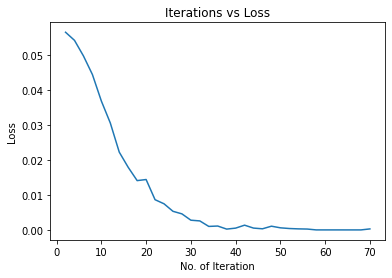

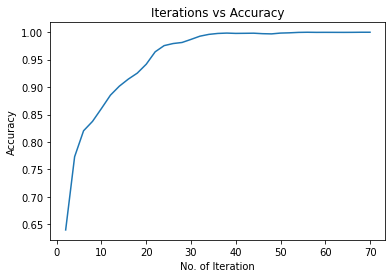

In [5]:
# 画出迭代中的损失
plt.figure(1)
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
# 画出迭代中的准确度
plt.figure(2)
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")

plt.show()

## 对比CNN与RNN

### 对CNN模型进行测试

In [4]:
import torch
import time
from torch.autograd import Variable
from torch.utils.data import Dataset

print("===================对CNN模型进行测试===================")

model_path="./src/SudokuCNN_model_1.40394.pth"
test_size=10000

# 为公平起见，CNN也是用cpu
device = torch.device("cpu")

# 加载数据集
batch_size = 100
# 这里因为是测试，所以就取分割数据中的训练集部分做测试了(不是训练模型的训练集！)
test_set, _ = load_dataset("./src/data/sudoku.csv", False, test_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# 加载模型
model = SudokuCNN()
model.to(device)
model.load_state_dict(torch.load(model_path))

# Testing the model
total = 0
correct = 0

# 开始计时
start = time.clock()
    
for test_quiz, test_label in test_loader:
    test_quiz, test_label = test_quiz.to(device), test_label.to(device)
    test_quiz = Variable(test_quiz.view(test_quiz.shape[0], 1, 9, 9))
    test_label = Variable(test_label.view(-1))

    outputs = model(test_quiz)
    outputs = outputs.view(-1, 9)

    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == test_label).sum()

    total += len(test_label)

# 结束计时
end = time.clock()
    
accuracy = correct * 100 / total

print("SudokuCNN accuracy: {}%".format(accuracy))
print("SudokuCNN cells in error: {}".format(total - correct))
print("SudokuCNN time = %s" % str(end - start))

print("====================================================")

===================对CNN模型进行测试===================
SudokuCNN accuracy: 75.1141128540039%
SudokuCNN cells in error: 141103
SudokuCNN time = 8.729239000000003


### 对RNN模型进行测试

In [9]:
print("===================对RNN模型进行测试===================")

model_path="./src/SudokuRNN_model_0.00001.pth"
test_size=10000

# 尝试使用GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 加载数据集
batch_size = 100
# 这里因为是测试，所以就取分割数据中的训练集部分做测试了(不是训练模型的训练集！)
test_set, _ = load_dataset("./src/data/sudoku.csv", True, test_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# 加载模型
model = SudokuRNN(create_constraint_mask())
model.to(device)
model.load_state_dict(torch.load(model_path))

# Testing the model
total = 0
correct = 0

# 开始计时
start = time.clock()

for test_quiz, test_label in test_loader:
    test_quiz, test_label = test_quiz.to(device), test_label.to(device)
    test_quiz = Variable(test_quiz)
    test_label = Variable(test_label)

    test_pred, test_fill = model(test_quiz)

    correct += (test_fill.max(dim=2)[1] == test_label.max(dim=2)[1]).sum().item()

    total += len(test_label) * 81

# 结束计时
end = time.clock()

accuracy = correct * 100 / total

print("SudokuRNN accuracy: {}%".format(accuracy))
print("SudokuRNN cells in error: {}".format(total - correct))
print("SudokuRNN time = %s" % str(end - start))

print("====================================================")

===================对RNN模型进行测试===================
SudokuRNN accuracy: 99.96490299823633%
SudokuRNN cells in error: 199
SudokuRNN time = 337.7354459999997


### 比较分析

从上面的结果我们发现:

- RNN的准确率远远超过CNN，RNN达到了99.6%的准确率，而CNN只有75%的准确率。

- RNN的错误单元格数目也远比CNN少，后者的错误数是前者的100倍。

- 但是RNN解决数独问题花费的时间比CNN多得多。

## 总结

这是我写的第二个大作业，我觉得数独问题和之前的服装分类问题是相通的：

- 服装分类问题是一个非常经典的多分类问题，我们需要对10种服装进行分类；

- 而数独问题可以认为是一个特殊的多分类问题，我们可以说是对每一个单元格进行分类，最后通过这些单元格的分类结果，得到数独的解决方案。

之前在做服装分类问题的时候，遇到的问题主要就是pytorch不熟练和图片预处理的效果不好；而这次写数独问题的时候，pytorch的基本用法已经比较熟练了，但是因为一开始对数独问题的理解不够透彻，并且对pytorch损失函数的细节不太清楚，产生了不少问题。

通过这个项目，我觉得我主要是学习到了pytorch损失函数的原理和期望输入的数据格式，以及如何灵活的运用卷积神经网络CNN来解决分类以外的问题。


#### 关于卷积神经网络解决数独问题是不是通过大量的参数记忆答案：

我在网上查阅资料的时候，有一部分文章和评论认为使用CNN或者NN解决数独是单纯的用非常多的参数去记住数独的每一个答案，这个观点我不知道是否正确，但是我对这个看法产生了比较大的兴趣，所以我后面有尝试修改我设计的卷积网络的参数，比如把卷积层节点调整为256或者512，再把全连接层的节点增加1000到2000个，再对网络进行训练和测试。

不过在我的测试中，我发现无论我怎么改参数（改太大会提示我GPU显存不够），这个网络的准确率最后都是75%左右，并且后面梯度下降的特别慢。所以我觉得可能卷积神经网络是通过空间特征提取，学习到了解决数独问题的函数，而不是仅仅通过大量的参数来记忆数独的答案。